In [2]:
# RE-ID Track Matching Visualization

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from reid_matcher import ReIDMatcher

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)


In [2]:
def load_track_crops(base_dir, clip_name, track_id, max_crops=4):
    """Load sample crops for a track"""
    crops_dir = Path(base_dir) / clip_name / "track_data" / "crops"
    csv_path = Path(base_dir) / clip_name / "track_data" / "tracking_results.csv"
    
    # Load tracking results
    df = pd.read_csv(csv_path)
    track_df = df[df['track_id'] == track_id].sort_values('frame')
    
    if len(track_df) == 0:
        return []
    
    # Sample frames evenly
    total_frames = len(track_df)
    if total_frames <= max_crops:
        sample_indices = list(range(total_frames))
    else:
        sample_indices = np.linspace(0, total_frames-1, max_crops, dtype=int)
    
    crops = []
    for idx in sample_indices:
        row = track_df.iloc[idx]
        crop_filename = f"f{int(row['frame'])}_t{int(track_id)}.jpg"
        crop_path = crops_dir / crop_filename
        
        if crop_path.exists():
            img = cv2.imread(str(crop_path))
            if img is not None:
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                crops.append(img)
    
    return crops

In [3]:
## Configuration

BASE_DIR = "/mnt/c/Users/felix/Downloads/mclarens_res_full"
QUERY_CLIP = "black-mclaren-suburban-parking-lot"
QUERY_TRACK_ID = 1

# Matching parameters
COMPARISON_MODE = "global_max"
SIMILARITY_THRESHOLD = 0.5
NUM_CROPS_TO_SHOW = 4

In [4]:
# Initialize matcher
matcher = ReIDMatcher(BASE_DIR)

# Find matches across all clips
print(f"Query: {QUERY_CLIP} - Track {QUERY_TRACK_ID}")
print(f"Searching across all clips...\n")

results = matcher.find_track_across_clips(
    query_clip=QUERY_CLIP,
    query_track_id=QUERY_TRACK_ID,
    comparison_mode=COMPARISON_MODE,
    similarity_threshold=SIMILARITY_THRESHOLD
)

Query: black-mclaren-suburban-parking-lot - Track 1
Searching across all clips...



In [5]:
# Load ground truth file
gt_file = Path(BASE_DIR) / "ground_truth.csv"
if gt_file.exists():
    print("\n" + "="*50)
    print("EVALUATION WITH GROUND TRUTH")
    print("="*50 + "\n")
    
    # Load ground truth
    gt_df = pd.read_csv(gt_file)
    
    # Filter to only our query
    gt_query = gt_df[(gt_df['query_clip'] == QUERY_CLIP) & (gt_df['query_track_id'] == QUERY_TRACK_ID)]
    
    if len(gt_query) > 0:
        # Prepare evaluation data
        eval_results = []
        
        for _, gt_row in gt_query.iterrows():
            gallery_clip = gt_row['gallery_clip']
            correct_track_id = gt_row['correct_track_id']
            
            # Find corresponding result
            matching_result = None
            for result in results:
                if result.gallery_clip == gallery_clip:
                    matching_result = result
                    break
            
            if matching_result:
                # Get ranked list of tracks by score
                ranked_tracks = sorted(matching_result.all_scores.items(), 
                                     key=lambda x: x[1], reverse=True)
                
                # Find rank of correct track
                rank = -1
                for i, (track_id, score) in enumerate(ranked_tracks):
                    if track_id == correct_track_id:
                        rank = i + 1
                        break
                
                eval_results.append({
                    'gallery_clip': gallery_clip,
                    'correct_track': correct_track_id,
                    'predicted_track': ranked_tracks[0][0] if ranked_tracks else None,
                    'rank': rank,
                    'score': matching_result.all_scores.get(correct_track_id, 0.0),
                    'top_score': ranked_tracks[0][1] if ranked_tracks else 0.0,
                    'correct': ranked_tracks[0][0] == correct_track_id if ranked_tracks else False
                })
        
        # Calculate metrics
        total_queries = len(eval_results)
        valid_queries = [r for r in eval_results if r['correct_track'] != -1 and r['correct_track'] != 777]
        
        if valid_queries:
            # Rank-based metrics
            rank_1 = sum(1 for r in valid_queries if r['rank'] == 1) / len(valid_queries) * 100
            rank_5 = sum(1 for r in valid_queries if 1 <= r['rank'] <= 5) / len(valid_queries) * 100
            rank_10 = sum(1 for r in valid_queries if 1 <= r['rank'] <= 10) / len(valid_queries) * 100
            
            # Mean rank
            valid_ranks = [r['rank'] for r in valid_queries if r['rank'] > 0]
            mean_rank = np.mean(valid_ranks) if valid_ranks else float('inf')
            
            # Print metrics
            print(f"Evaluation on {len(valid_queries)} valid queries (excluding -1/777):\n")
            print(f"Rank-1 Accuracy:  {rank_1:.1f}%")
            print(f"Rank-5 Accuracy:  {rank_5:.1f}%")
            print(f"Rank-10 Accuracy: {rank_10:.1f}%")
            print(f"Mean Rank:        {mean_rank:.2f}")
            
            # Detailed results table
            print("\nDetailed Results:")
            eval_df = pd.DataFrame(eval_results)
            
            # Add visual indicators
            eval_df['status'] = eval_df.apply(
                lambda x: '✓' if x['correct'] else 
                         ('○' if x['rank'] > 0 and x['rank'] <= 5 else 
                          ('✗' if x['rank'] == -1 else '◎')), axis=1)
            
            # Select columns to display
            display_df = eval_df[['gallery_clip', 'correct_track', 'predicted_track', 
                                  'rank', 'score', 'top_score', 'status']]
            display(display_df)
            
            # Legend
            print("\nLegend: ✓ = Rank-1 correct, ○ = In top-5, ◎ = In top-10, ✗ = Not found")
            
            # # CMC Curve
            # ranks = list(range(1, 11))
            # cmc_values = []
            # for r in ranks:
            #     accuracy = sum(1 for res in valid_queries if 1 <= res['rank'] <= r) / len(valid_queries) * 100
            #     cmc_values.append(accuracy)
            
            # plt.figure(figsize=(8, 6))
            # plt.plot(ranks, cmc_values, 'b-o', linewidth=2, markersize=8)
            # plt.xlabel('Rank')
            # plt.ylabel('Recognition Rate (%)')
            # plt.title('CMC Curve - Cumulative Match Characteristic')
            # plt.grid(True, alpha=0.3)
            # plt.xlim(0.5, 10.5)
            # plt.ylim(0, 105)
            # plt.xticks(ranks)
            # plt.show()
            
        else:
            print("No valid ground truth entries found (all are -1 or 777)")
            
    else:
        print(f"No ground truth found for query: {QUERY_CLIP} - Track {QUERY_TRACK_ID}")
else:
    print(f"\nNo ground truth file found at: {gt_file}")
    print("Create ground_truth.csv in the base directory to enable evaluation")


EVALUATION WITH GROUND TRUTH

Evaluation on 14 valid queries (excluding -1/777):

Rank-1 Accuracy:  64.3%
Rank-5 Accuracy:  100.0%
Rank-10 Accuracy: 100.0%
Mean Rank:        1.43

Detailed Results:


,gallery_clip,correct_track,predicted_track,rank,score,top_score,status
0,mclarens-coastal-chase-1,125,125,1,0.866193,0.866193,✓
1,mclarens-coastal-chase-2,135,135,1,0.866946,0.866946,✓
2,mclarens-coastal-chase-3,159,158,2,0.889579,0.893063,○
3,mclarens-coastal-chase-4,170,170,1,0.909808,0.909808,✓
4,mclarens-coastal-chase-5,198,198,1,0.919235,0.919235,✓
5,mclarens-coastal-chase-6,225,225,1,0.903835,0.903835,✓
6,mclarens-suburban-chase-1,248,248,1,0.927678,0.927678,✓
7,mclarens-suburban-chase-2,295,295,1,0.955416,0.955416,✓
8,mclarens-suburban-sunset-chase-1,385,405,2,0.945661,0.953809,○
9,mclarens-suburban-sunset-chase-2,444,459,2,0.911575,0.915221,○



Legend: ✓ = Rank-1 correct, ○ = In top-5, ◎ = In top-10, ✗ = Not found



Analyzing: black-mclaren-suburban-parking-lot Track 1 → mclarens-coastal-chase-3
Ground truth: Track 159

Top 2 matches in mclarens-coastal-chase-3:
  Track 158: 0.893
  Track 159: 0.890 ← CORRECT
  Track 160: 0.835
  Track 163: 0.833
  Track 161: 0.825

--- Track 158 (Score: 0.893) ---


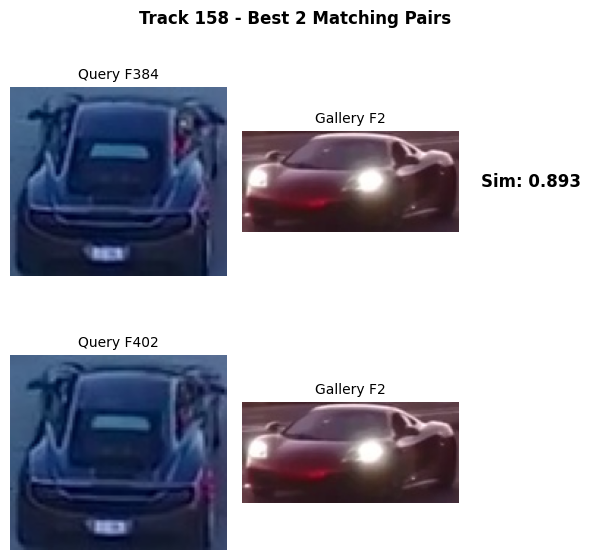

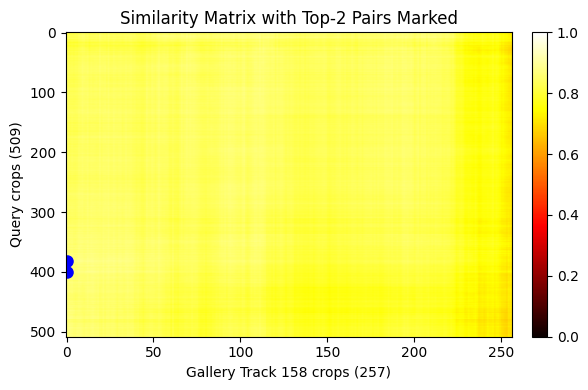


--- Track 159 (Score: 0.890) ---


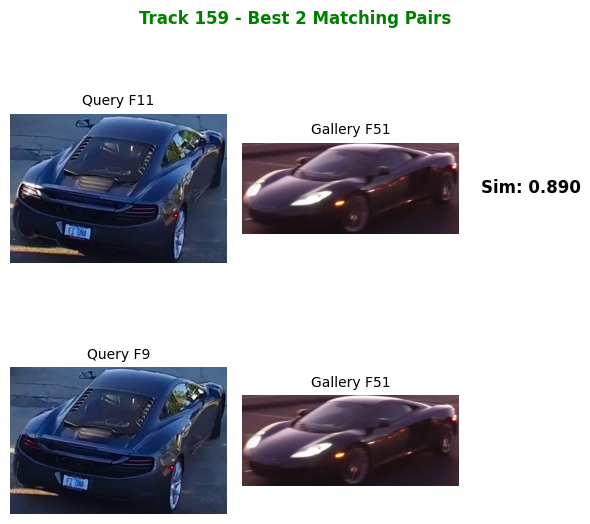

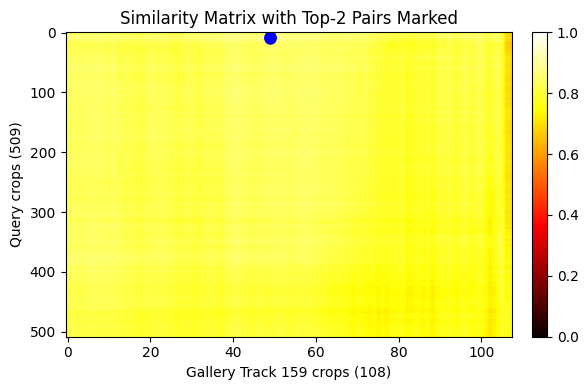


--- Track 160 (Score: 0.835) ---


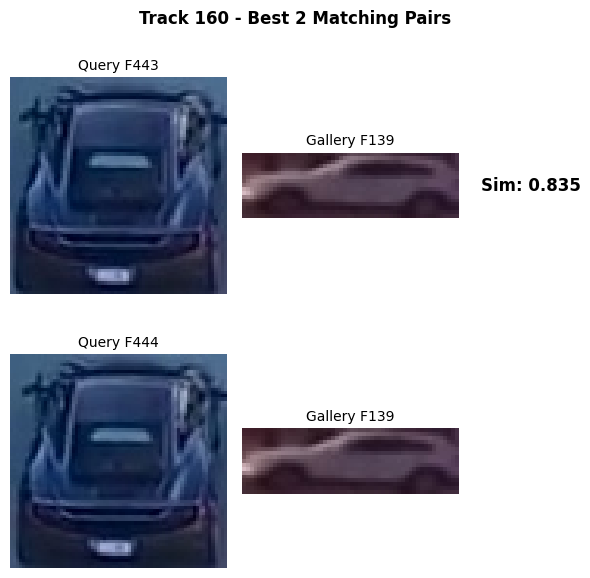

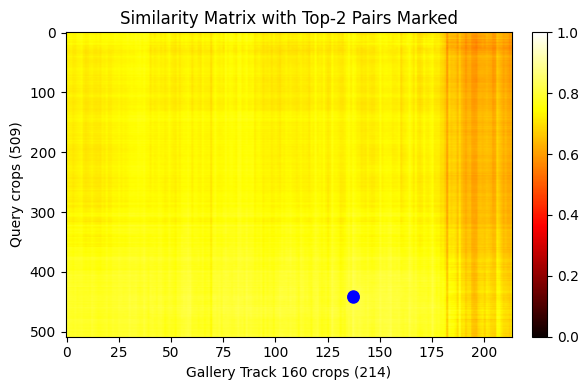


--- Track 163 (Score: 0.833) ---


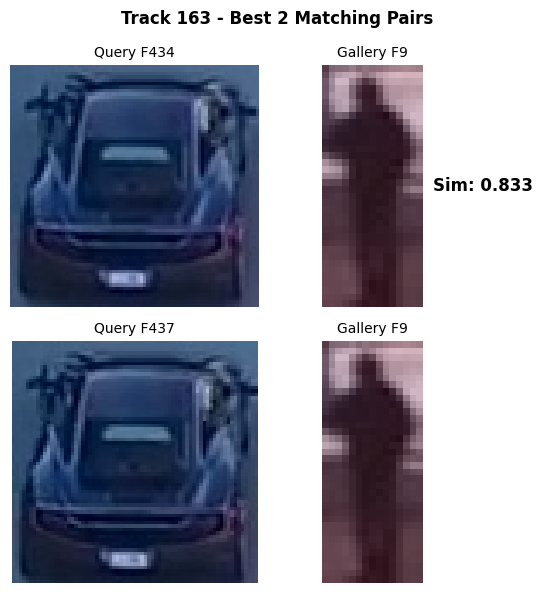

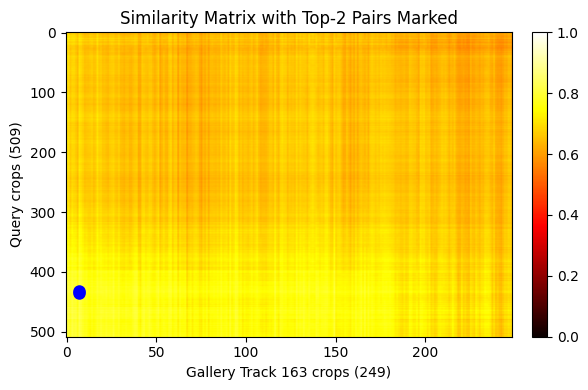

In [ ]:
## Drill Down on Specific Matches - Show Best Matching Pairs

def analyze_match_details(query_clip, query_track_id, gallery_clip, correct_track_id=None, 
                         top_k_pairs=3, num_tracks_to_show=2):
    """Analyze detailed similarity matrix and show the best matching crop pairs"""
    
    # Get the result for this specific gallery
    result = matcher.match_track(
        query_clip=query_clip,
        query_track_id=query_track_id,
        gallery_clip=gallery_clip,
        comparison_mode=COMPARISON_MODE
    )
    
    # Load features to get individual crop similarities
    query_features = matcher.load_clip_features(query_clip)
    gallery_features = matcher.load_clip_features(gallery_clip)
    
    query_track_features = query_features['tracks'][query_track_id]['features']
    
    # Get top tracks from gallery
    sorted_tracks = sorted(result.all_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"\nAnalyzing: {query_clip} Track {query_track_id} → {gallery_clip}")
    if correct_track_id:
        print(f"Ground truth: Track {correct_track_id}")
    print(f"\nTop {top_k_pairs} matches in {gallery_clip}:")
    for track_id, score in sorted_tracks:
        marker = " ← CORRECT" if track_id == correct_track_id else ""
        print(f"  Track {track_id}: {score:.3f}{marker}")
    
    # For each top track, find and display best matching pairs
    for track_idx, (track_id, score) in enumerate(sorted_tracks[:num_tracks_to_show]):
        print(f"\n--- Track {track_id} (Score: {score:.3f}) ---")
        
        gallery_track_features = gallery_features['tracks'][track_id]['features']
        
        # Compute similarity matrix
        sim_matrix = matcher.compute_similarity_matrix(
            query_track_features,
            gallery_track_features,
            metric='cosine'
        )
        print(sim_matrix.shape)
        
        # Find top-k highest similarity pairs
        flat_indices = np.argpartition(sim_matrix.ravel(), -top_k_pairs)[-top_k_pairs:]
        flat_indices = flat_indices[np.argsort(sim_matrix.ravel()[flat_indices])[::-1]]
        
        # Convert to 2D indices
        top_pairs = []
        for flat_idx in flat_indices:
            i, j = np.unravel_index(flat_idx, sim_matrix.shape)
            similarity = sim_matrix[i, j]
            top_pairs.append((i, j, similarity))
        
        # Load tracking info to get frame numbers
        query_csv = pd.read_csv(Path(BASE_DIR) / query_clip / "track_data" / "tracking_results.csv")
        gallery_csv = pd.read_csv(Path(BASE_DIR) / gallery_clip / "track_data" / "tracking_results.csv")
        
        query_track_df = query_csv[query_csv['track_id'] == query_track_id].sort_values('frame')
        gallery_track_df = gallery_csv[gallery_csv['track_id'] == track_id].sort_values('frame')
        
        # Display the best matching pairs
        fig, axes = plt.subplots(top_k_pairs, 2, figsize=(6, 3*top_k_pairs))
        if top_k_pairs == 1:
            axes = axes.reshape(1, 2)
        
        for pair_idx, (q_idx, g_idx, sim) in enumerate(top_pairs):
            # Get frame numbers
            q_frame = query_track_df.iloc[q_idx]['frame']
            g_frame = gallery_track_df.iloc[g_idx]['frame']
            
            # Load the specific crops
            q_crop_path = Path(BASE_DIR) / query_clip / "track_data" / "crops" / f"f{int(q_frame)}_t{int(query_track_id)}.jpg"
            g_crop_path = Path(BASE_DIR) / gallery_clip / "track_data" / "crops" / f"f{int(g_frame)}_t{int(track_id)}.jpg"
            
            # Query crop
            ax = axes[pair_idx, 0]
            if q_crop_path.exists():
                q_img = cv2.imread(str(q_crop_path))
                q_img = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)
                ax.imshow(q_img)
                ax.set_title(f"Query F{int(q_frame)}", fontsize=10)
            ax.axis('off')
            
            # Gallery crop
            ax = axes[pair_idx, 1]
            if g_crop_path.exists():
                g_img = cv2.imread(str(g_crop_path))
                g_img = cv2.cvtColor(g_img, cv2.COLOR_BGR2RGB)
                ax.imshow(g_img)
                ax.set_title(f"Gallery F{int(g_frame)}", fontsize=10)
            ax.axis('off')
            
            # Add similarity score
            if pair_idx == 0:
                ax.text(1.1, 0.5, f"Sim: {sim:.3f}", transform=ax.transAxes,
                       fontsize=12, weight='bold', va='center')
        
        # Add track label
        color = 'green' if track_id == correct_track_id else 'black'
        fig.suptitle(f'Track {track_id} - Best {top_k_pairs} Matching Pairs', 
                    fontsize=12, weight='bold', color=color)
        plt.tight_layout()
        plt.show()
        
        # Also show the similarity matrix heatmap
        plt.figure(figsize=(6, 4))
        im = plt.imshow(sim_matrix, cmap='hot', aspect='auto', vmin=0, vmax=1)
        
        # Mark the top pairs on the heatmap
        for q_idx, g_idx, _ in top_pairs:
            plt.plot(g_idx, q_idx, 'bo', markersize=8)
        
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.xlabel(f'Gallery Track {track_id} crops ({sim_matrix.shape[1]})')
        plt.ylabel(f'Query crops ({sim_matrix.shape[0]})')
        plt.title(f'Similarity Matrix with Top-{top_k_pairs} Pairs Marked', fontsize=12)
        plt.tight_layout()
        plt.show()

# Example usage
analyze_match_details(QUERY_CLIP, QUERY_TRACK_ID, "mclarens-coastal-chase-3", 
                     correct_track_id=159, top_k_pairs=2, num_tracks_to_show=4)

In [ ]:
query_crops = load_track_crops(BASE_DIR, QUERY_CLIP, QUERY_TRACK_ID, NUM_CROPS_TO_SHOW)

if query_crops:
    fig, axes = plt.subplots(1, len(query_crops), figsize=(3*len(query_crops), 3))
    if len(query_crops) == 1:
        axes = [axes]
    
    for i, crop in enumerate(query_crops):
        axes[i].imshow(crop)
        axes[i].axis('off')
    
    plt.suptitle(f"QUERY: {QUERY_CLIP} - Track {QUERY_TRACK_ID}", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
# print(f"\nResults for each gallery clip:\n")

# for result in results:
#     # Get the best track (highest scoring)
#     best_track = max(result.all_scores, key=result.all_scores.get)
#     best_score = result.all_scores[best_track]
    
#     # Load crops for the best track
#     gallery_crops = load_track_crops(BASE_DIR, result.gallery_clip, best_track, NUM_CROPS_TO_SHOW)
    
#     if gallery_crops:
#         fig, axes = plt.subplots(1, len(gallery_crops), figsize=(3*len(gallery_crops), 3))
#         if len(gallery_crops) == 1:
#             axes = [axes]
        
#         for i, crop in enumerate(gallery_crops):
#             axes[i].imshow(crop)
#             axes[i].axis('off')
        
#         # Title with match info
#         match_status = "MATCH" if result.matched_track is not None else "NO MATCH"
#         color = 'green' if result.matched_track is not None else 'red'
        
#         plt.suptitle(
#             f"{result.gallery_clip} - Track {best_track} - Score: {best_score:.3f} - {match_status}", 
#             fontsize=12, 
#             weight='bold',
#             color=color
#         )
#         plt.tight_layout()
#         plt.show()
#     else:
#         print(f"{result.gallery_clip}: No crops found for track {best_track}")


In [ ]:
# print("\nSummary:")
# summary_data = []
# for result in results:
#     best_track = max(result.all_scores, key=result.all_scores.get)
#     summary_data.append({
#         'Gallery Clip': result.gallery_clip,
#         'Best Track': best_track,
#         'Score': f"{result.all_scores[best_track]:.3f}",
#         'Match': 'YES' if result.matched_track is not None else 'NO'
#     })

# summary_df = pd.DataFrame(summary_data)
# display(summary_df)